In [1]:
from pathlib import Path
from collections import defaultdict
from ghub_utils import files
from ReadFinalModule import ReadFinal
import EOFandPlots2 as eof
import regex as re
import yaml
import traceback

In [2]:
%ls

EOFandPlots.py   ReadFinalModule.py  __pycache__/  test.ipynb
EOFandPlots2.py  __init__.py         main.ipynb    test_output.txt


In [3]:
models_dir = files.DIR_SAMPLE_DATA / 'models'

In [4]:
fnpat = r'^(?P<field>\w+)_GIS_(?<a>\w+)_(?<b>\w+)_(?P<exp>\w+).nc'
dpat = r'(?P<a>\w+)-(?P<b>\w+)'

## Select Fields & Experiment

In [5]:
exps = ['ctrl', 'init', 'asmb']
fields = ['acabf', 'dlithkdt', 'libmassbf', 'litempbot', 'litempsnic', 
          'lithk', 'orog', 'strbasemag', 'uvelbase', 'vvelbase', 'uvelsurf', 
          'vvelsurf']
eof_fields = ['acabf', 'dlithkdt', 'libmassbf', 'litempbot', 'litempsnic', 
          'lithk', 'orog', 'strbasemag', 'velbase', 'velsurf']

In [6]:
with open(files.DIR_PROJECT / 'conf.yml', 'r') as f:
    y = yaml.safe_load(f)

    models_all = list(y['model_paths'].keys())
    # possible model exclusions
    exclude_all = y['exclude']

In [7]:
models_exclude = []
# models_exclude = exclude['thermal']
# models_exclude = exclude['libmassbf']
# models_exclude = exclude['thermal'] + exclude['ghf']
# models_exclude = exclude['dhdt']

In [8]:
# set difference is OK because no duplicate items
models = sorted(list(set(models_all).difference(models_exclude)))

### Initializing

In [9]:
single_fields = ['acabf', 'dlithkdt', 'libmassbf', 'litempbot', 'litempsnic', 
          'lithk', 'orog', 'strbasemag']

In [10]:
group_fields = {('uvelsurf', 'vvelsurf'): 'velsurf', 
                ('uvelbase', 'vvelbase'): 'velbase'}

In [11]:
part_fields = [
    ({'uvelsurf', 'vvelsurf', 'orog'}, 
     {'velsurf', 'orog'}),
    ({'uvelsurf', 'vvelsurf', 'orog', 'acabf'}, 
     {'velsurf', 'orog', 'acabf'}),
    ({'uvelsurf', 'vvelsurf', 'orog', 'acabf', 'dlithkdt'}, 
     {'velsurf', 'orog', 'acabf', 'dlithkdt'}),
    ({}, {})
]

In [12]:
# fields to read
# thermal = ['litempsnic', 'litempbot']
# strbasemag is missing somewhere in asmb and ctrl runs
# dynamic_read = ['uvelsurf', 'vvelsurf', 'uvelbase', 'vvelbase', 'strbasemag']
# dynamic_eof = ['velsurf', 'velbase', 'strbasemag']
# mass = ['lithk', 'orog', 'acabf']
#
# fields = dynamic_read + ['orog', 'acabf']
# eof_fields = dynamic_eof + ['orog', 'acabf']
# fields = dynamic_read + ['orog', 'dlithkdt']
# eof_fields = dynamic_eof + ['orog', 'dlithkdt']
# fields = dynamic_read + ['orog', 'dlithkdt', 'acabf']
# eof_fields = dynamic_eof + ['orog', 'dlithkdt', 'acabf']
# fields = dynamic_read + ['orog']# + ['lithk'] #['orog']
# eof_fields = dynamic_eof + ['orog'] # + ['lithk'] # + ['orog']
# fields = dynamic_read
# eof_fields = dynamic_eof
#
#
# fields = ['uvelsurf', 'vvelsurf', 'orog']
# eof_fields = ['velsurf', 'orog']
#
# fields = ['uvelsurf', 'vvelsurf', 'orog', 'acabf']
# eof_fields = ['velsurf', 'orog', 'acabf']
#
# use dhdt_exclude
# fields = ['uvelsurf', 'vvelsurf', 'orog', 'acabf', 'dlithkdt']
# eof_fields = ['velsurf', 'orog', 'acabf', 'dlithkdt']
#
# # use thermal_exclude
# fields = ['uvelsurf', 'vvelsurf', 'orog', 'acabf', 'litempsnic']
# eof_fields = ['velsurf', 'orog', 'acabf', 'litempsnic']
#
# fields = ['uvelbase', 'vvelbase', 'strbasemag']
# eof_fields = ['velbase', 'strbasemag']
#
# # use thermal_exclude
# fields = ['uvelbase', 'vvelbase', 'strbasemag', 'litempbot']
# eof_fields = ['velbase', 'strbasemag', 'litempbot']
#
# # use libmassbf_exclude
# fields = ['libmassbf']
# eof_fields = ['libmassbf']
# fields = ['uvelbase', 'vvelbase', 'strbasemag', 'libmassbf']
# eof_fields = ['velbase', 'strbasemag', 'libmassbf']
#
# # use thermal_exclude and libmassbf_exclude
# fields = ['uvelbase', 'vvelbase', 'strbasemag', 'litempbot', 'libmassbf']
# eof_fields = ['velbase', 'strbasemag', 'litempbot', 'libmassbf']
#
# # use libmassbf_exclude, dhdt_exclude
# fields = ['acabf', 'libmassbf', 'dlithkdt']
# eof_fields = ['acabf', 'libmassbf', 'dlithkdt']
#
# # use dhdt_exclude
# fields = ['acabf', 'dlithkdt']
# eof_fields = ['acabf', 'dlithkdt']
#
# # use thermal_exclude, bhf_exclude
# fields = ['litempsnic', 'litempbot', 'hfgeoubed']
# eof_fields = ['litempsnic', 'litempbot', 'hfgeoubed']
#
# # for all
# fields = ['lithk', 'uvelsurf', 'vvelsurf', 'acabf', 'uvelbase', 'vvelbase', 'strbasemag']
# eof_fields = ['lithk', 'velsurf', 'acabf', 'velbase', 'strbasemag']


# fields = ['orog']
# fields = ['uvelsurf', 'vvelsurf', 'lithk']
# fields = ['lithk']
# fields = ['uvelsurf', 'vvelsurf']
# fields = ['uvelbase', 'vvelbase']

# fields = ['acabf']
# fields = ['dlithkdt']
# fields = ['litempsnic']
# fields = ['strbasemag']
# fields = ['topg']
# fields = ['libmassbf']
# fields to analyze
# # note that velsurf will be created later from uvelsurf, vvelsurf
# eof_fields = ['velsurf', 'lithk']
# eof_fields = ['orog']
# eof_fields = ['lithk']
# eof_fields = ['velsurf']
# eof_fields = ['velbase']
# eof_fields = ['topg']
# eof_fields = ['libmassbf']
# eof_fields = ['acabf']
# eof_fields = ['dlithkdt']
# eof_fields = ['litempsnic']
# eof_fields = ['strbasemag']

# experiment = 'init'
experiment = 'ctrl'
# experiment = 'asmb'
# size of the first dimension of the data
step = 21  # only applies when experiment is ctrl or asmb

In [13]:
fields = dict(zip(single_fields, single_fields))
fields.update(group_fields)
fields

{'acabf': 'acabf',
 'dlithkdt': 'dlithkdt',
 'libmassbf': 'libmassbf',
 'litempbot': 'litempbot',
 'litempsnic': 'litempsnic',
 'lithk': 'lithk',
 'orog': 'orog',
 'strbasemag': 'strbasemag',
 ('uvelsurf', 'vvelsurf'): 'velsurf',
 ('uvelbase', 'vvelbase'): 'velbase'}

In [56]:
outcomes = dict()
passed = []
fnf = defaultdict(list)
ie = []

In [46]:
fn_pat = r'No such file .+: b\'(.+.nc)\''

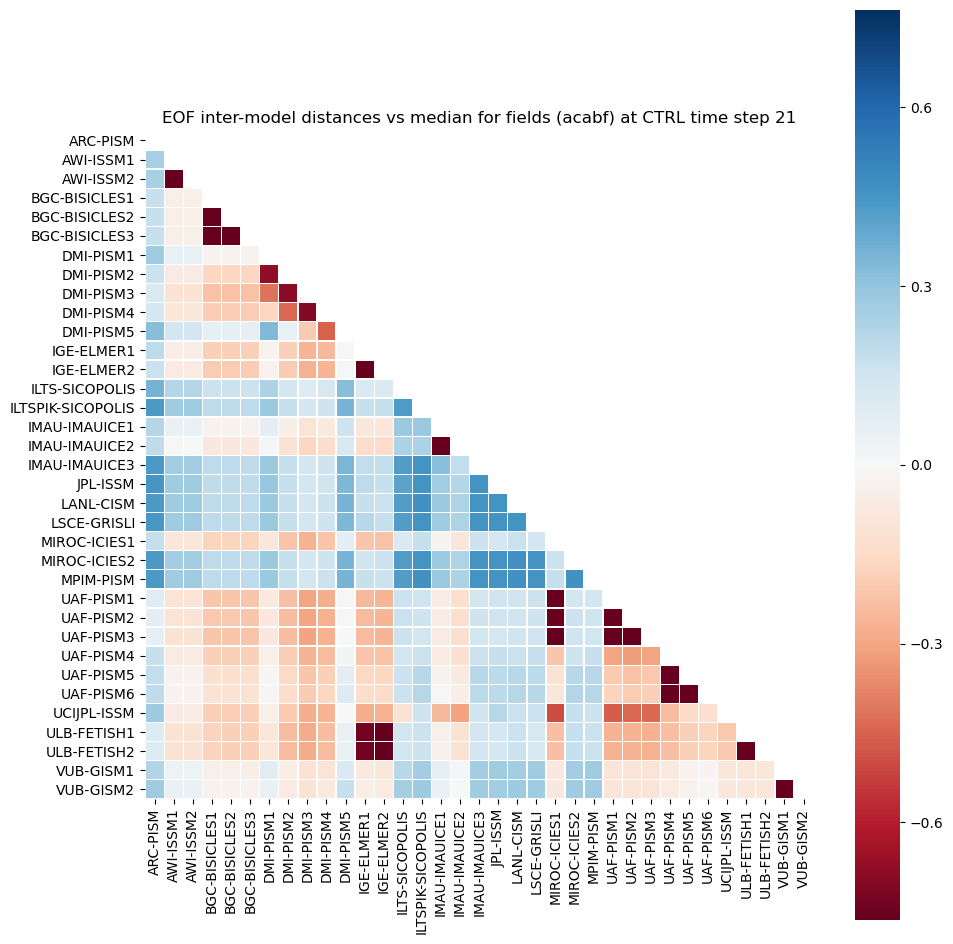

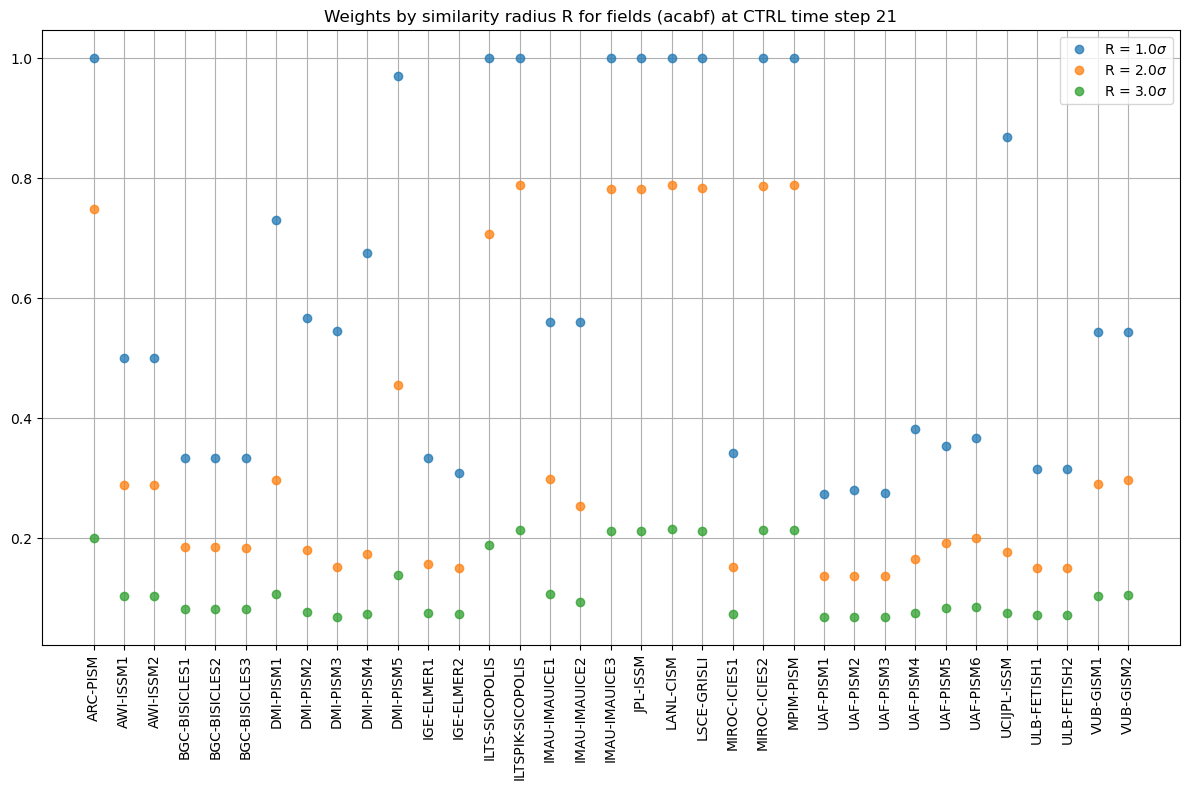

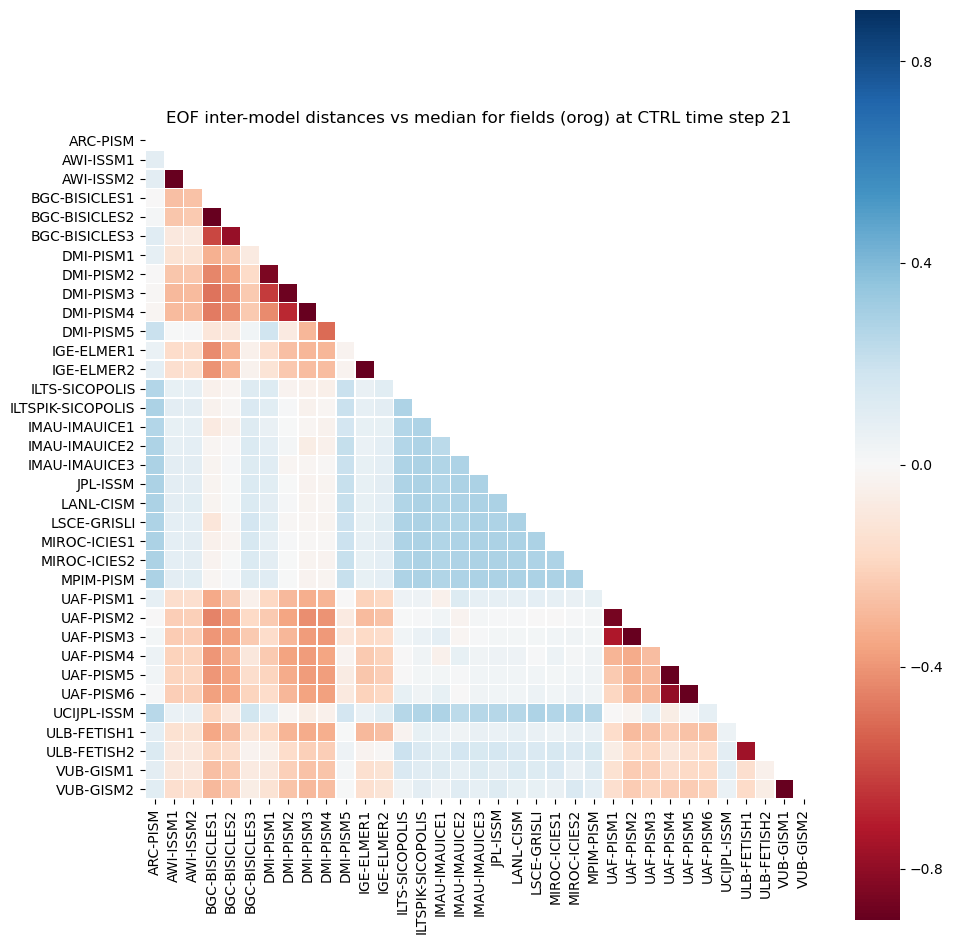

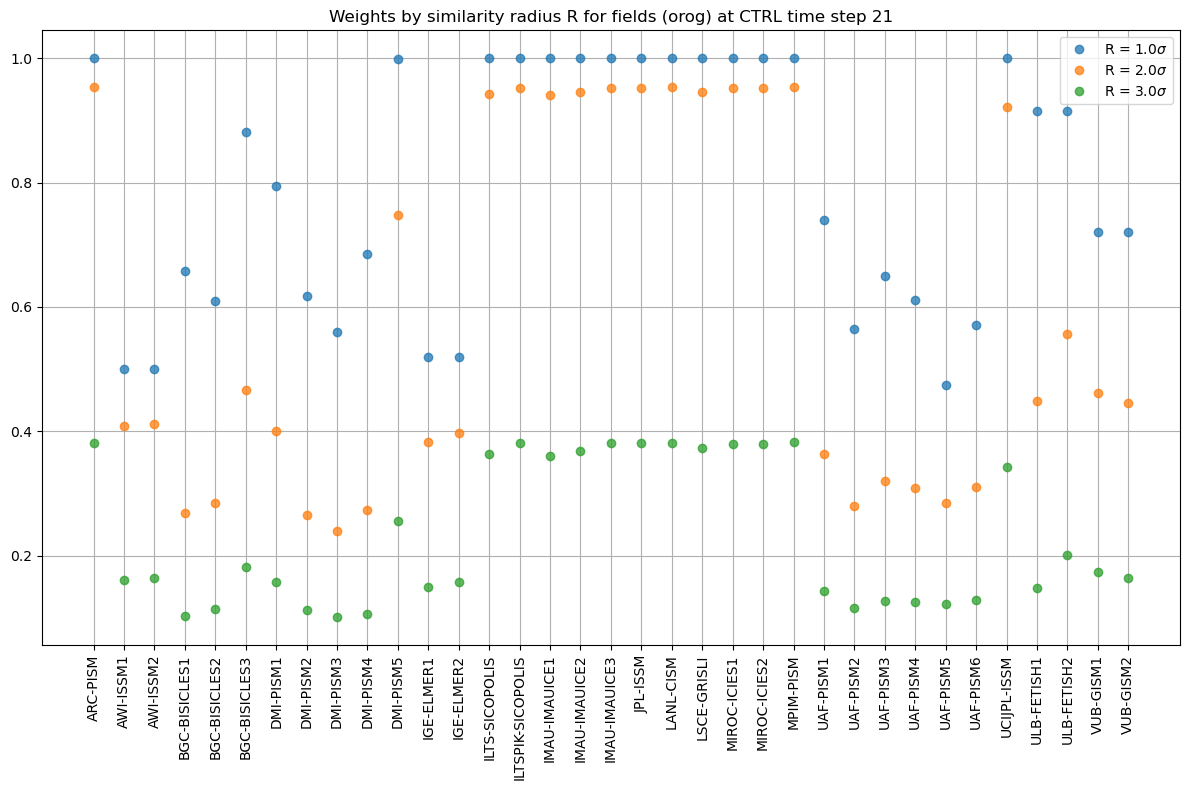

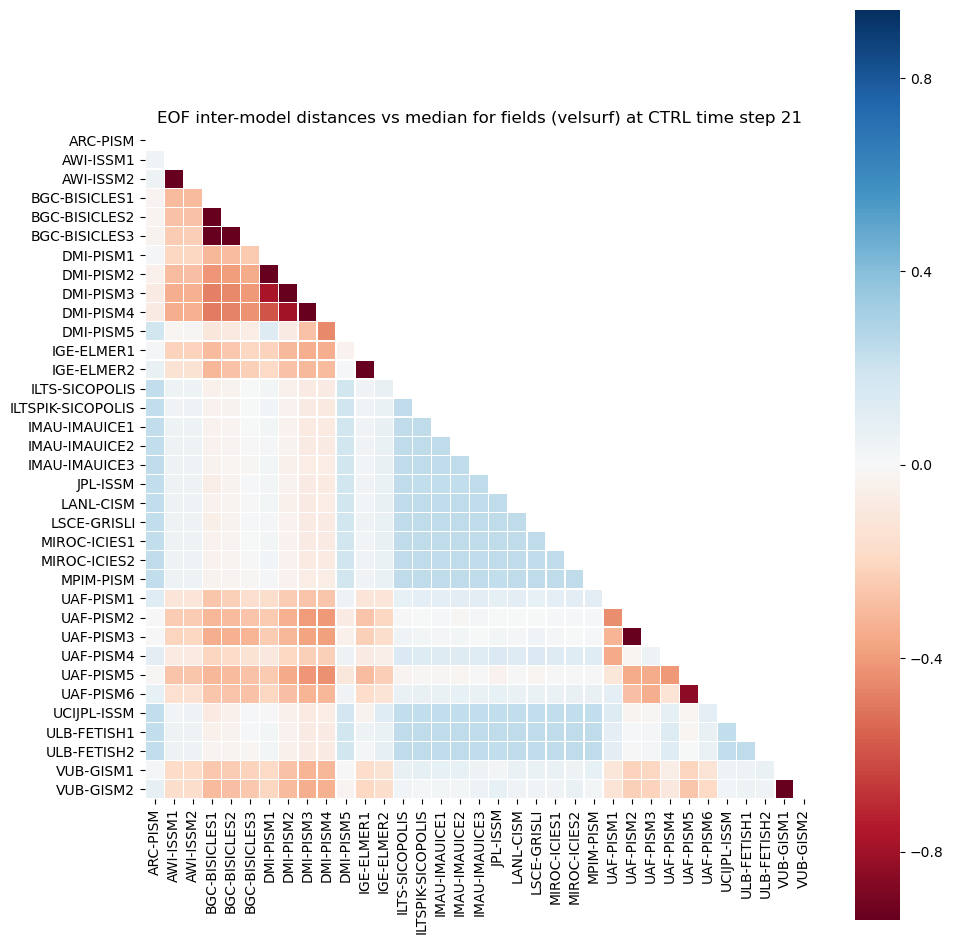

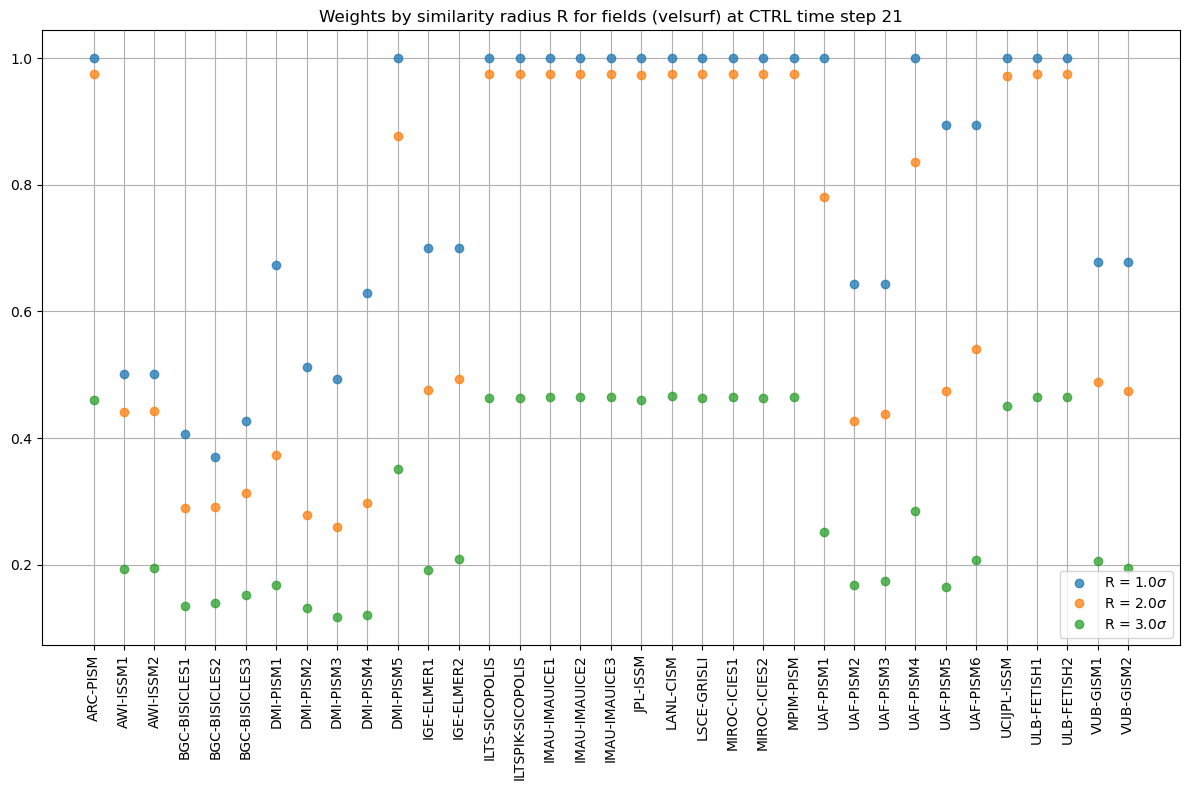

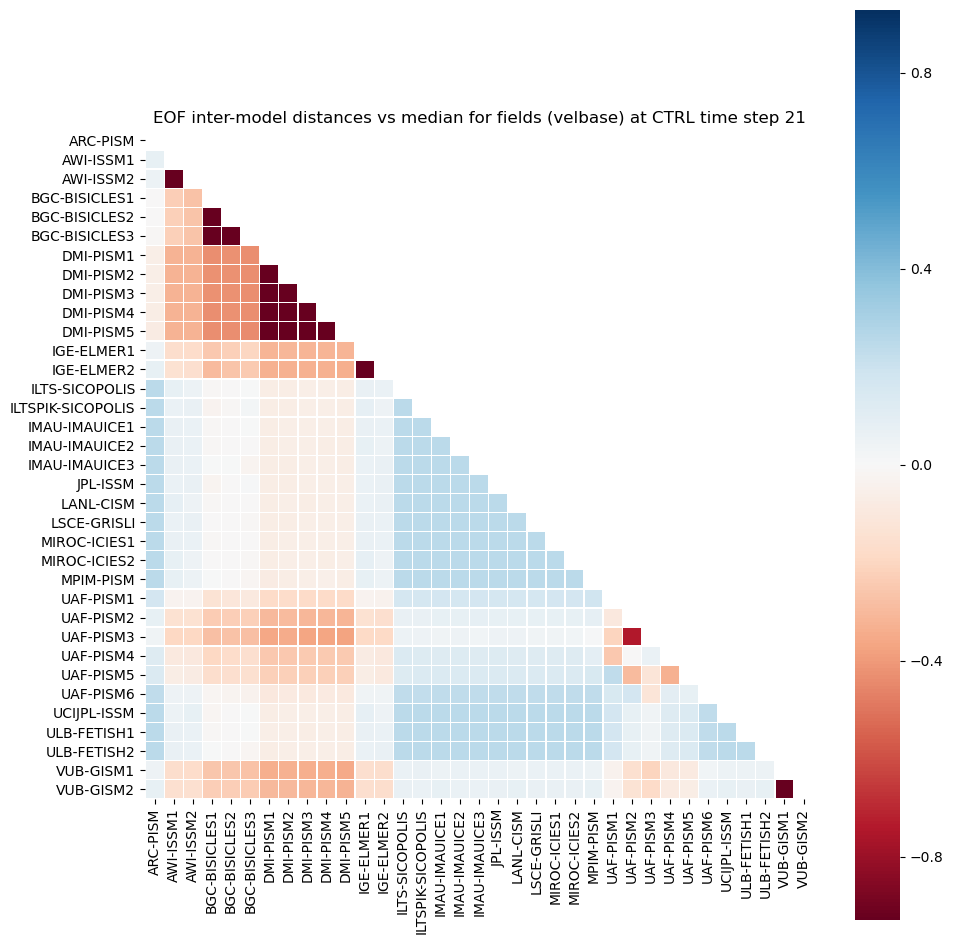

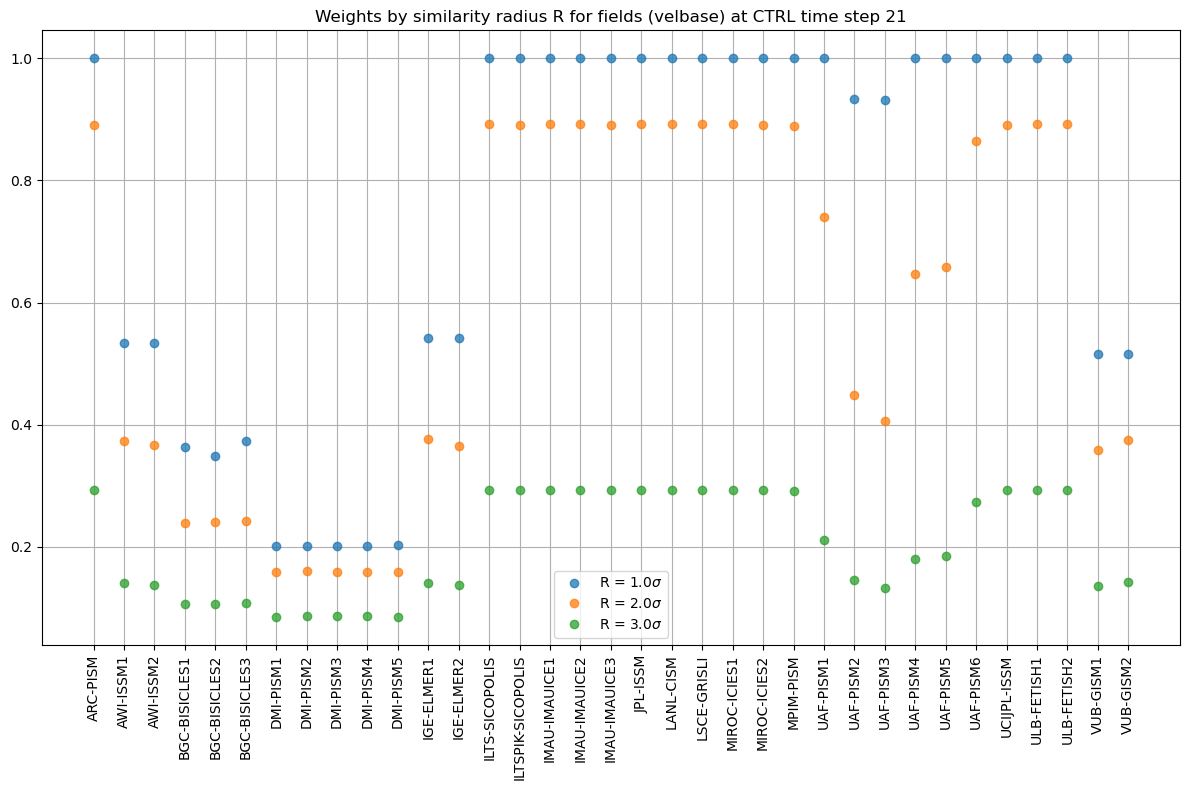

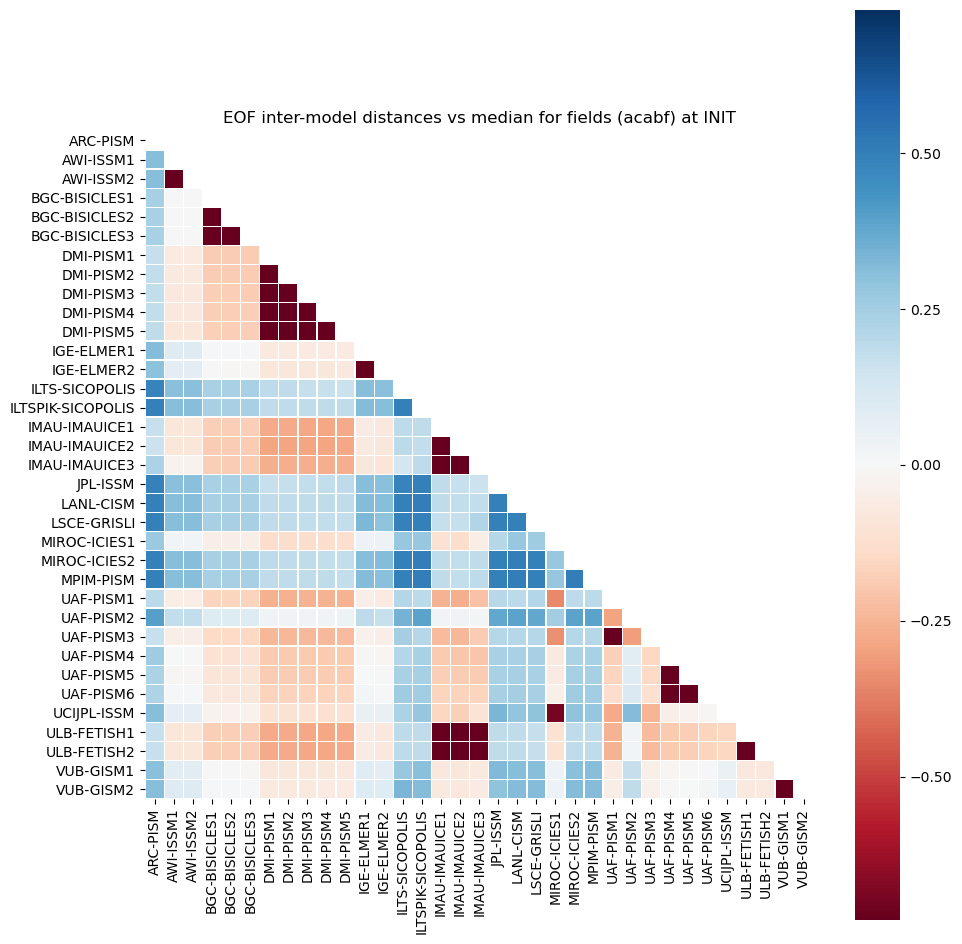

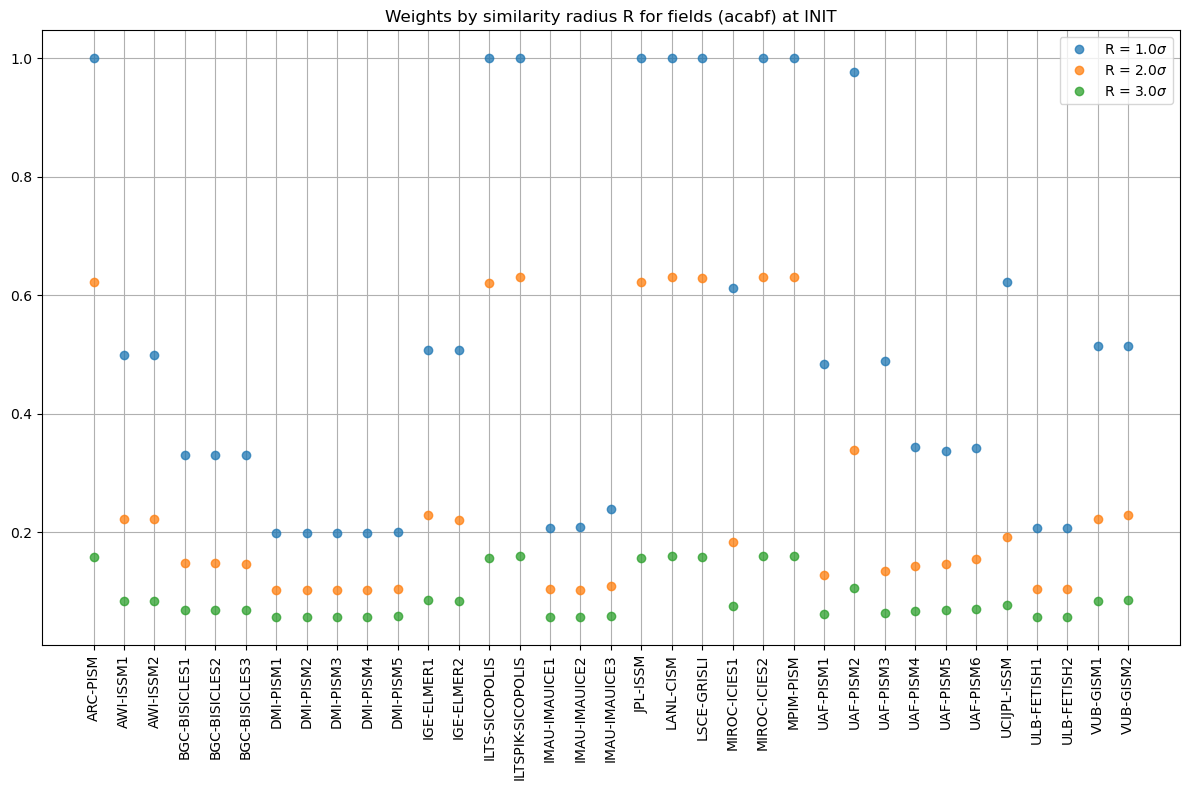

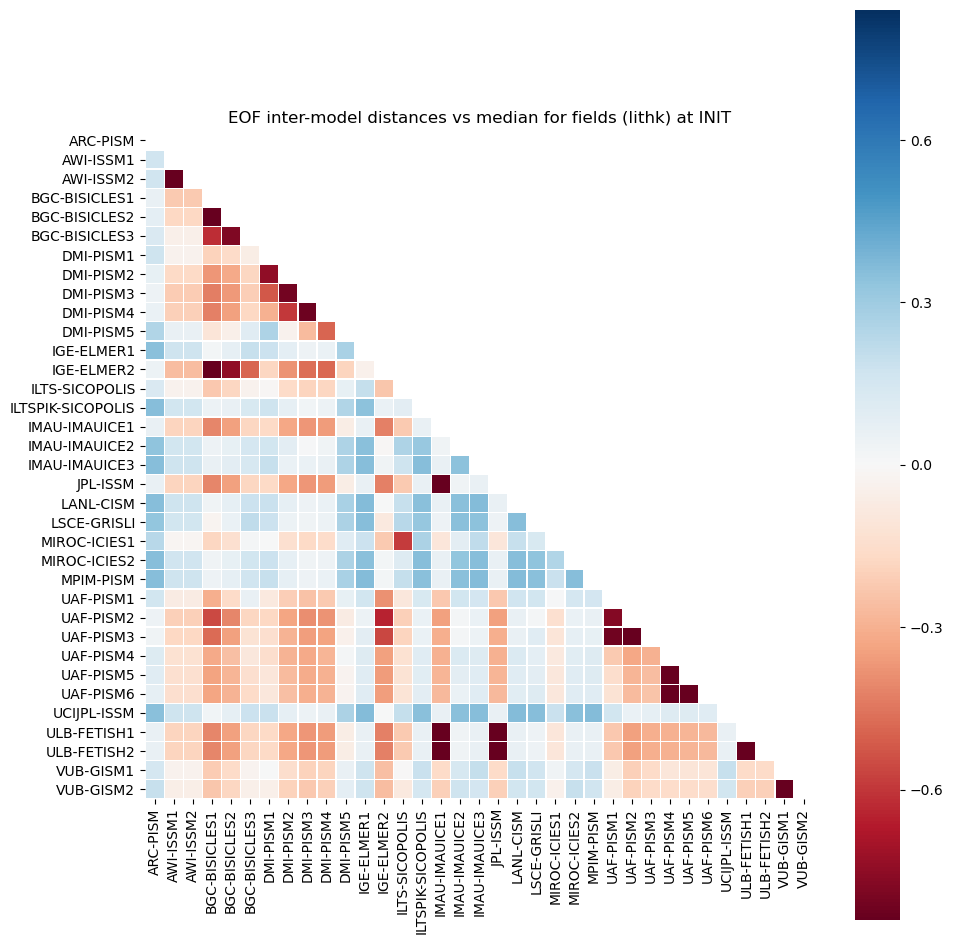

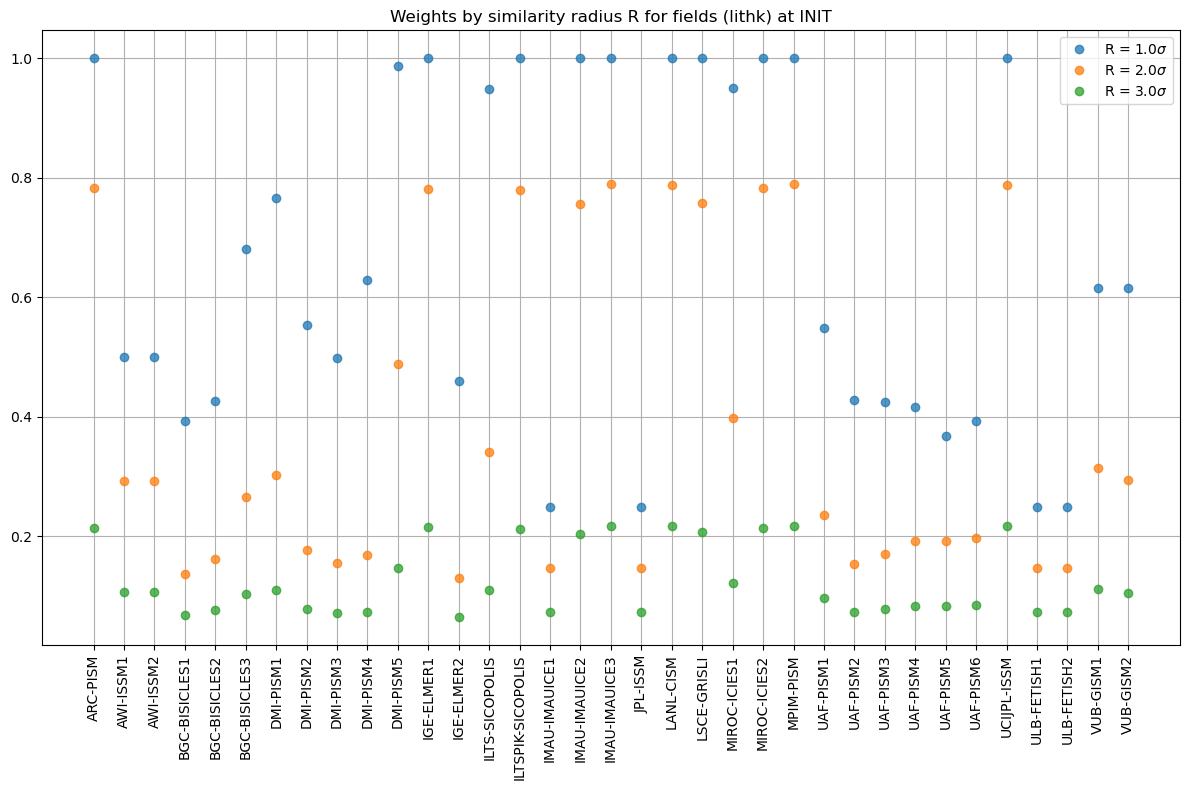

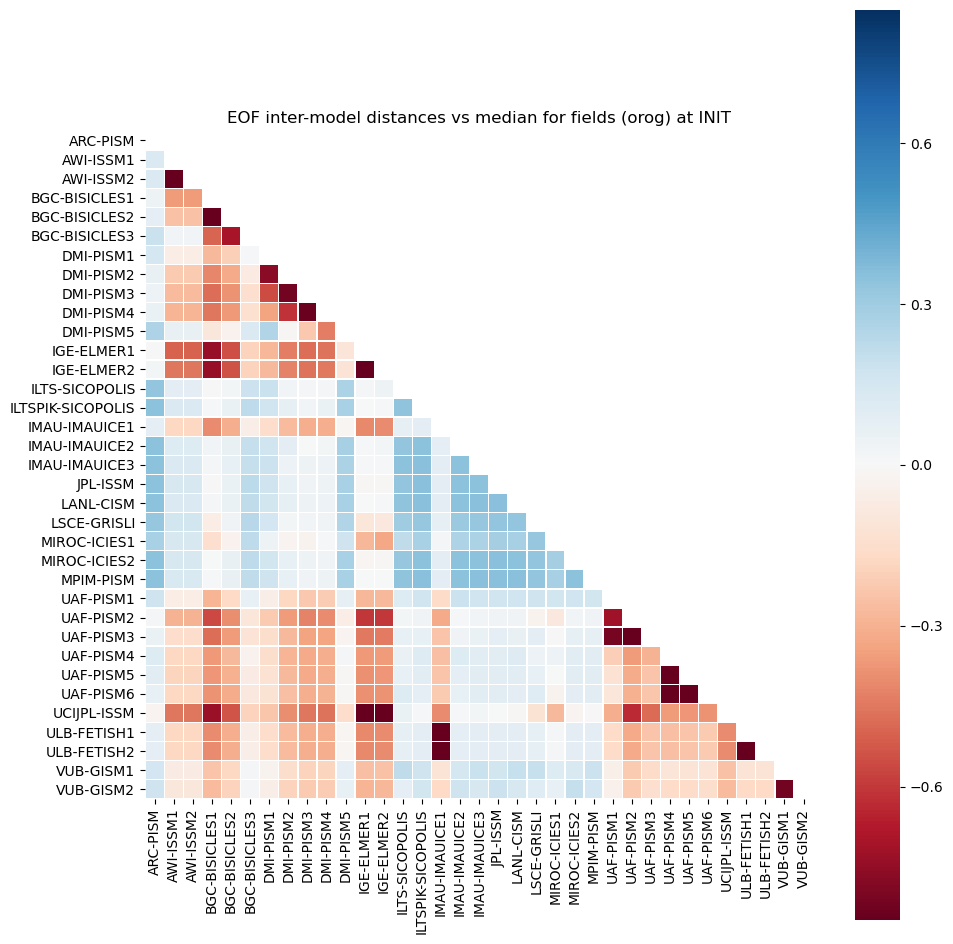

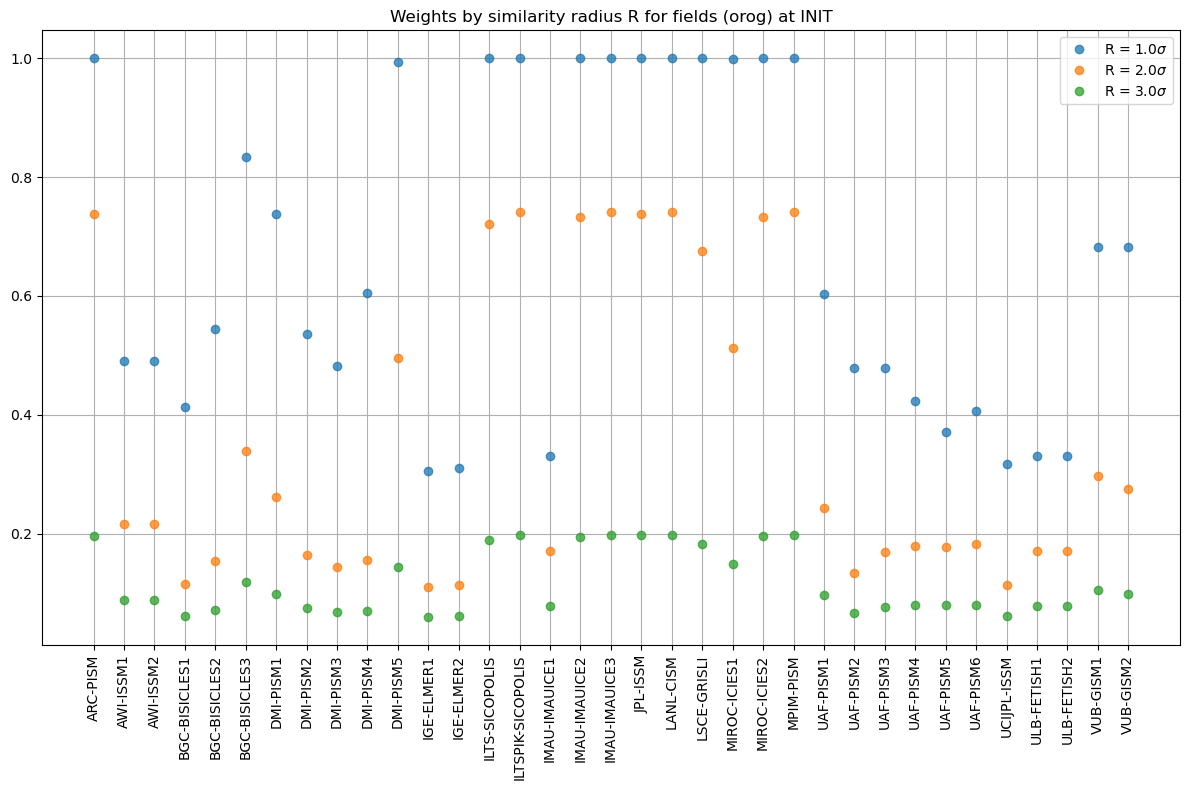

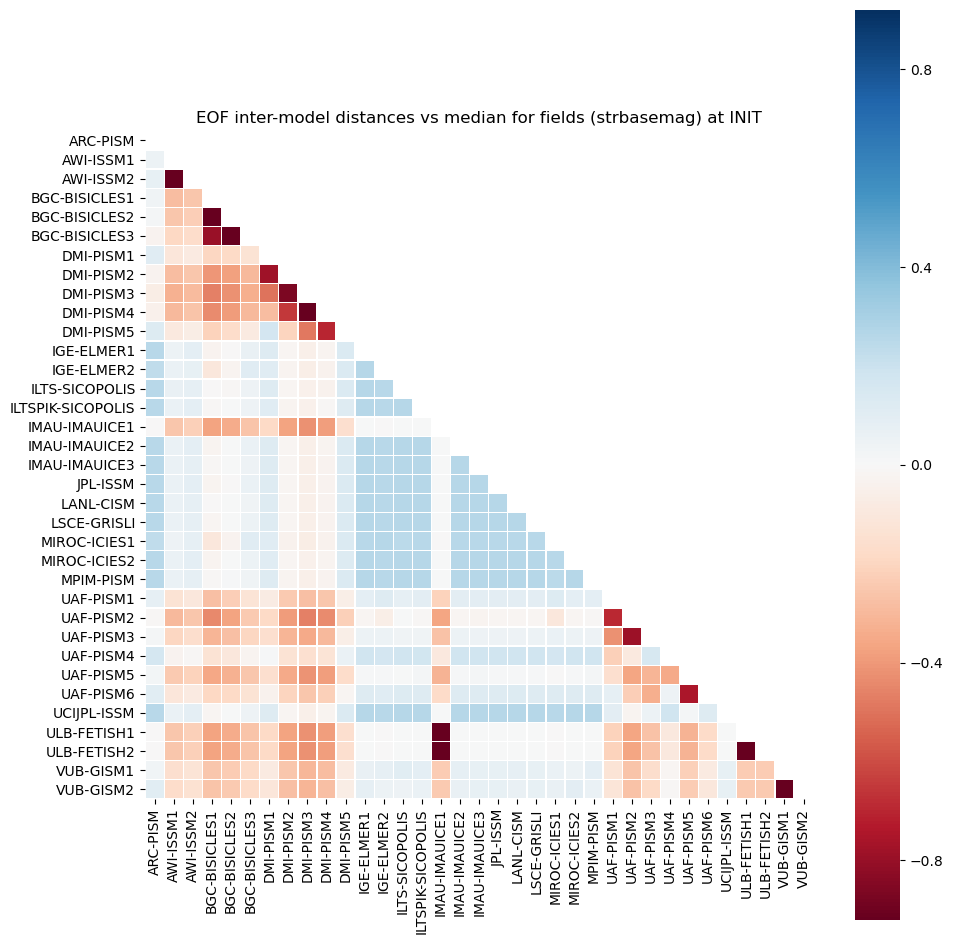

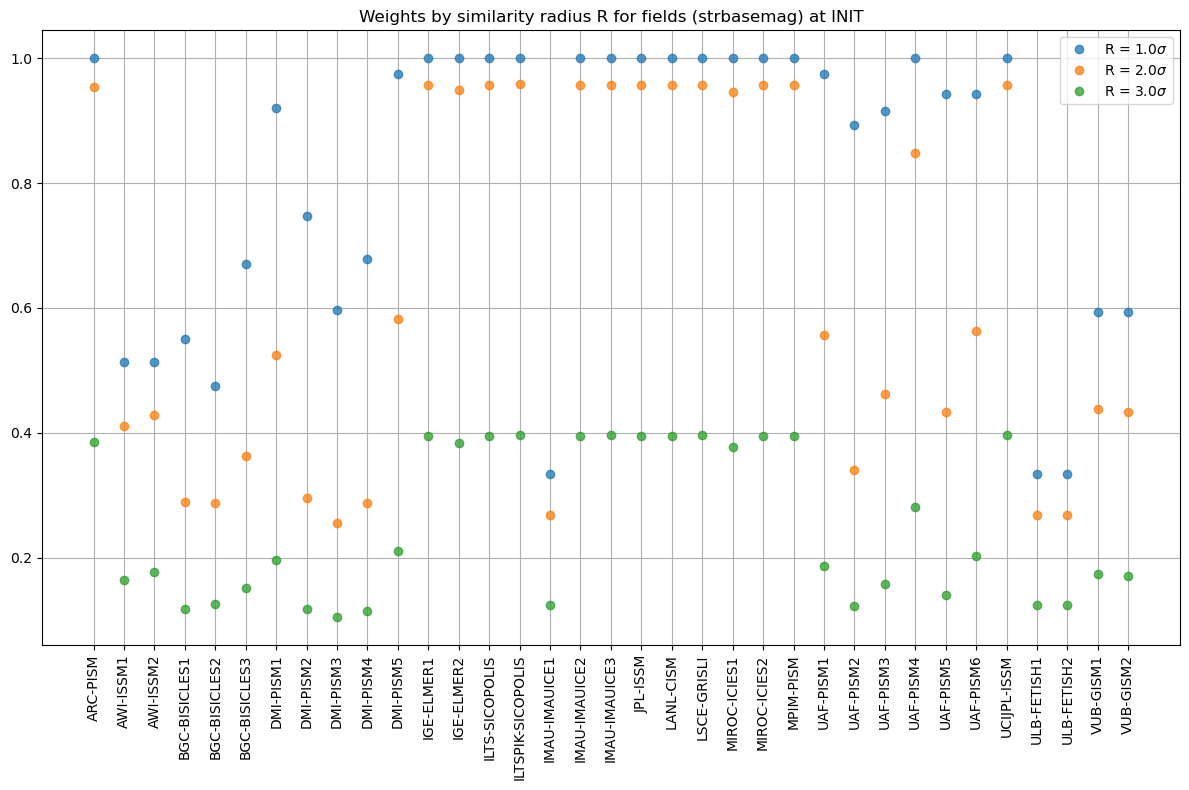

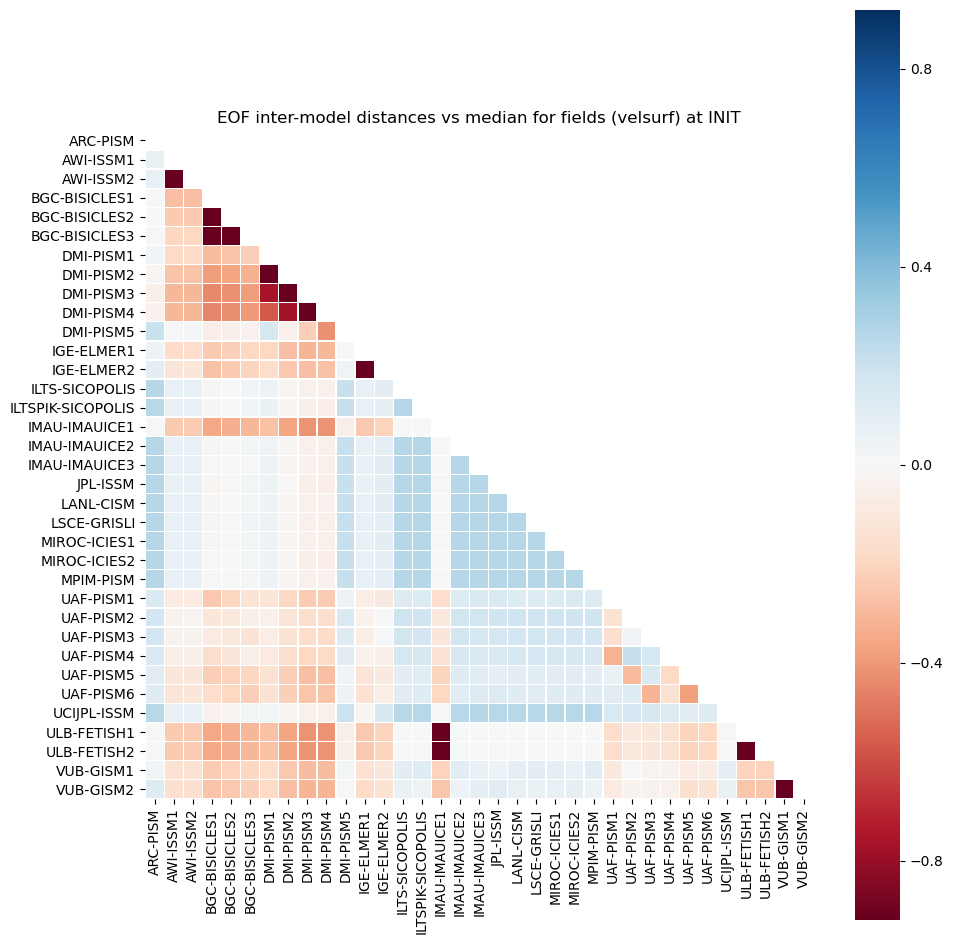

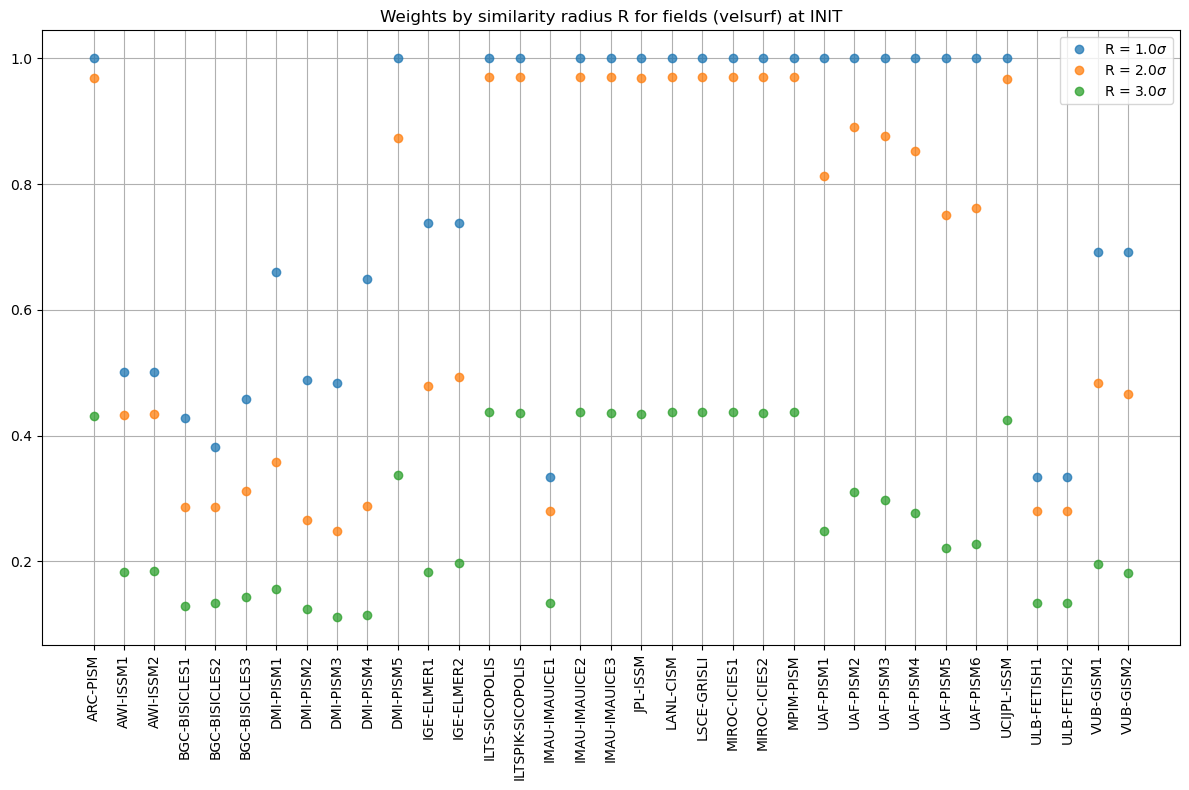

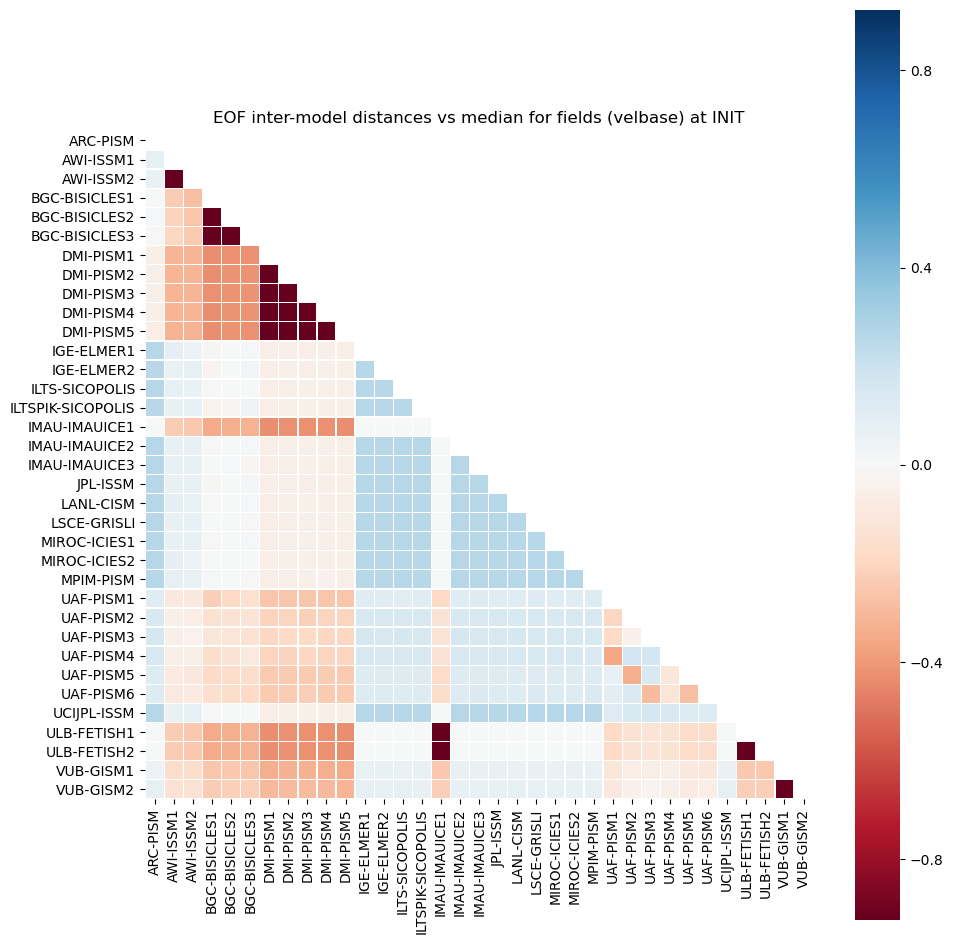

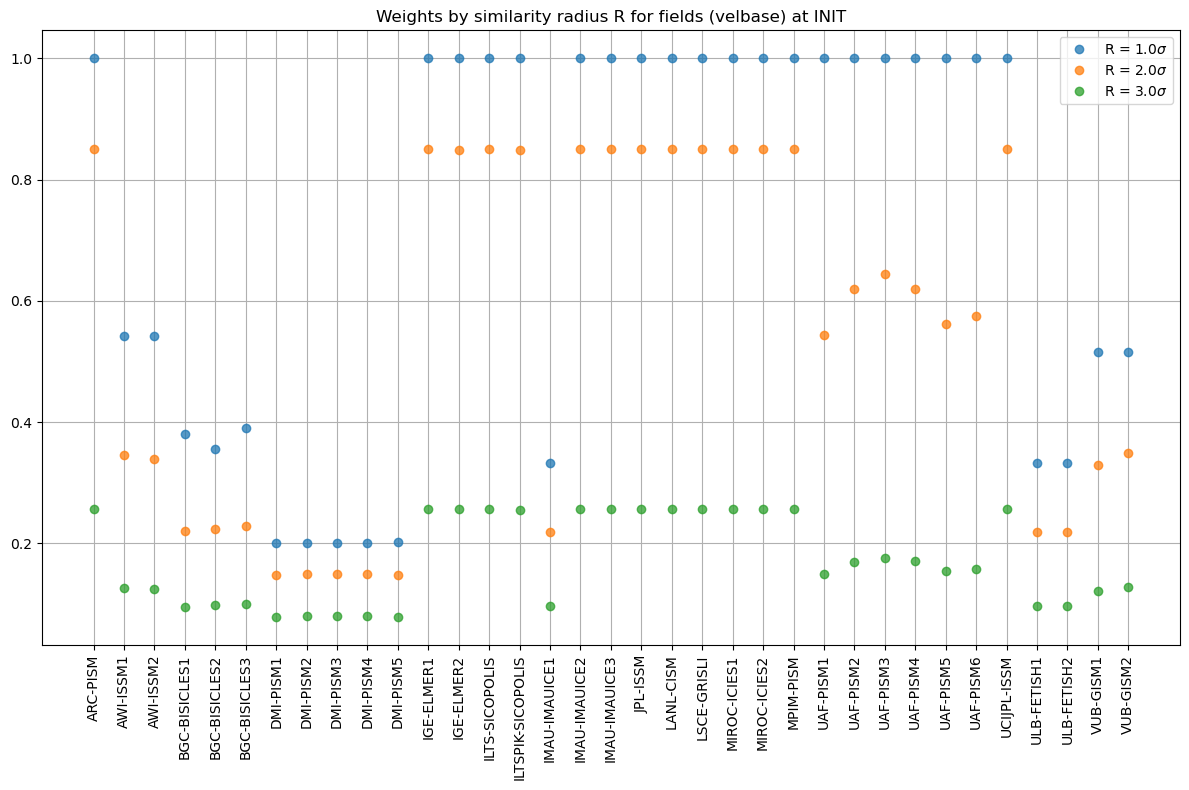

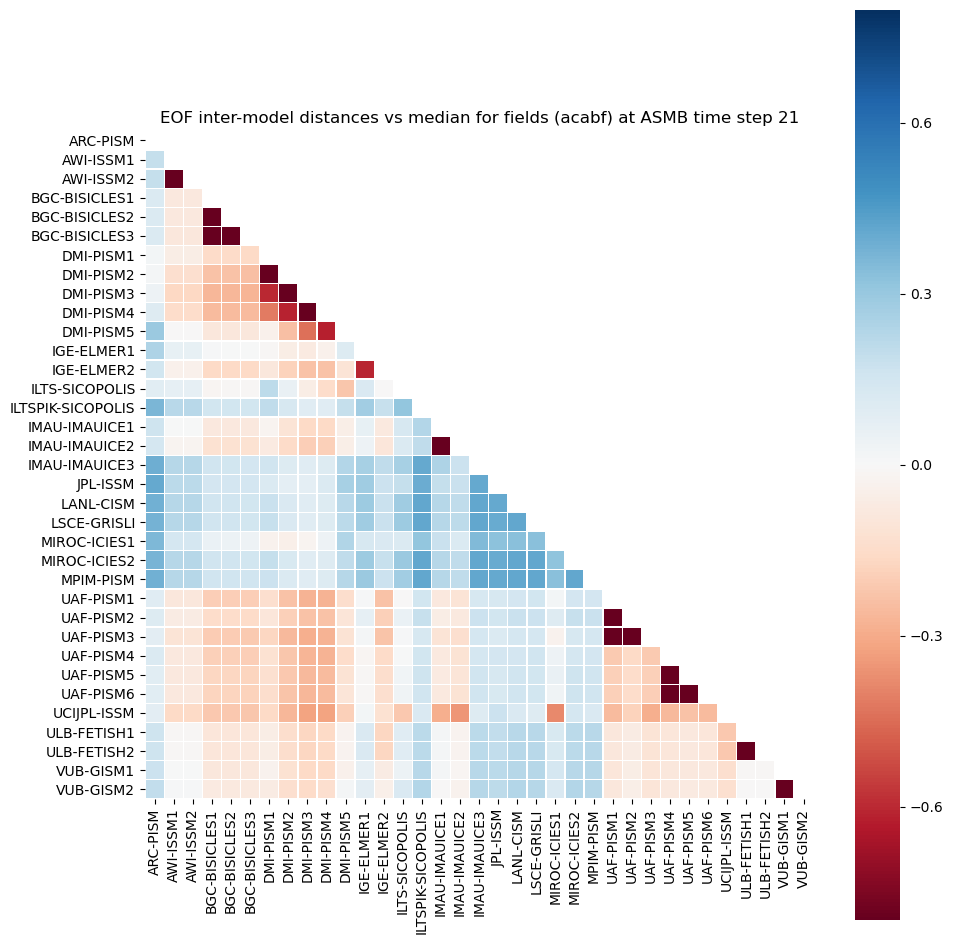

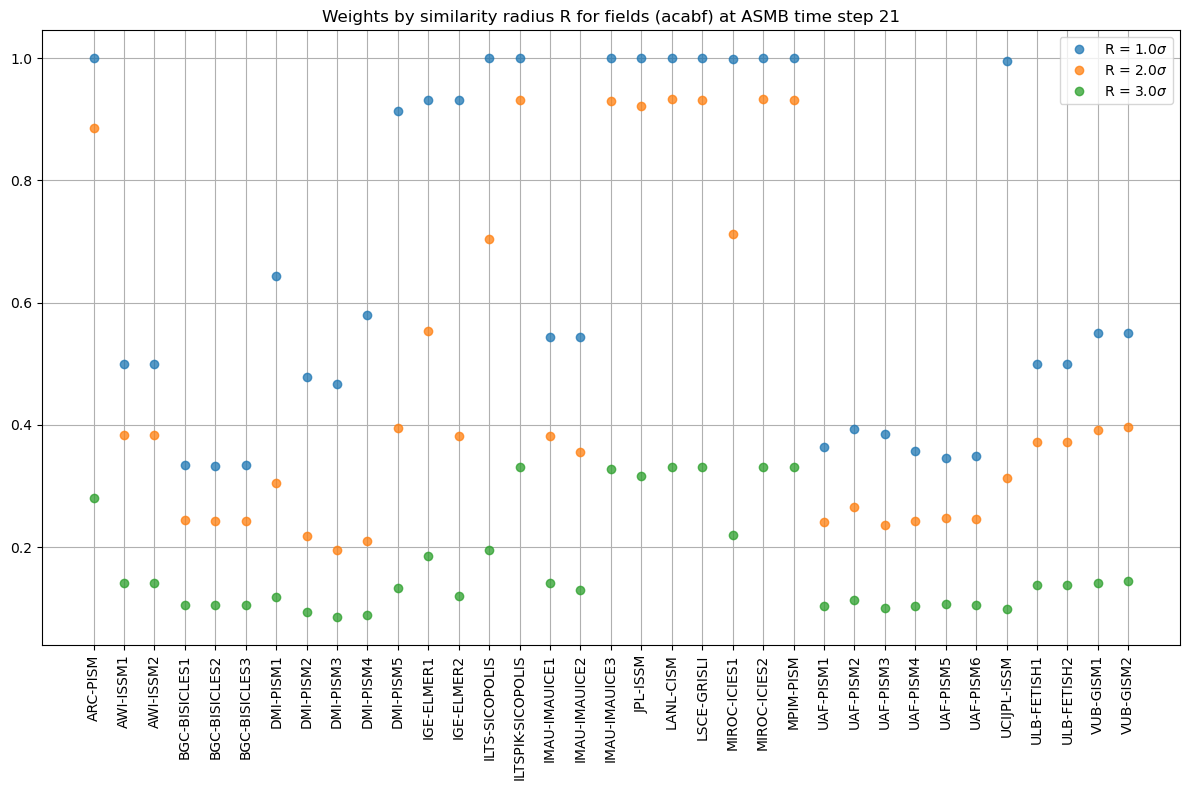

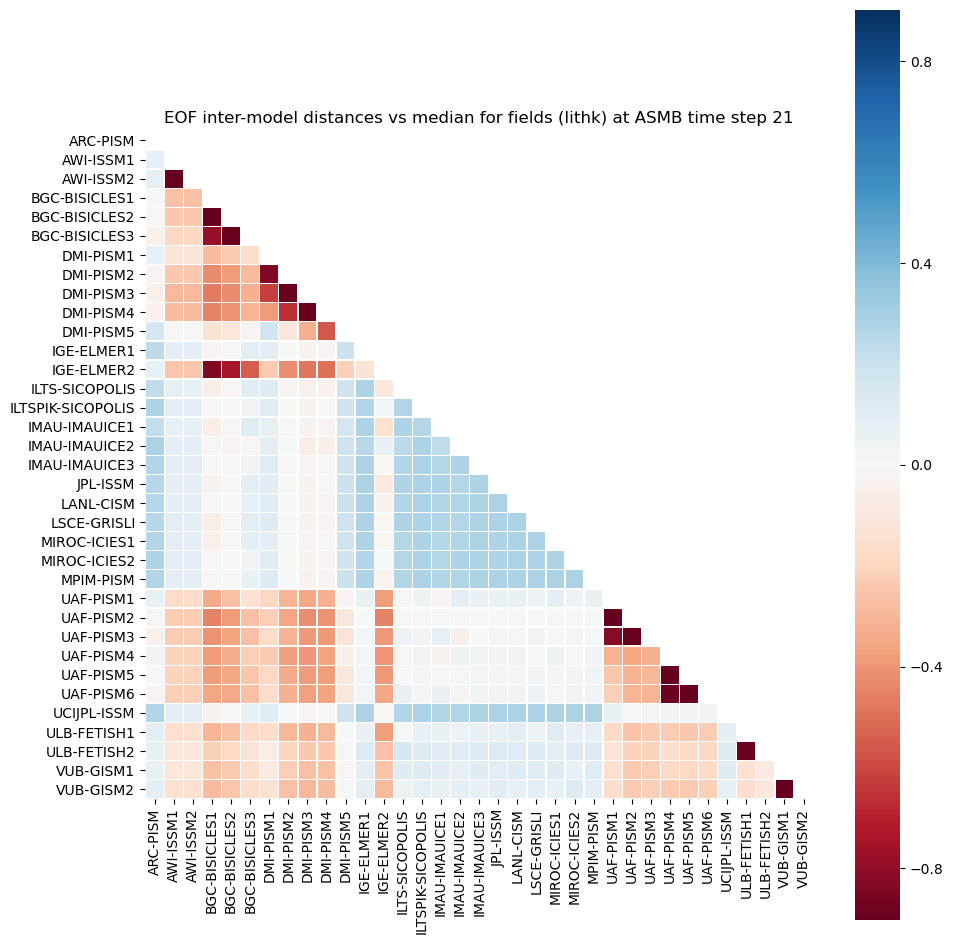

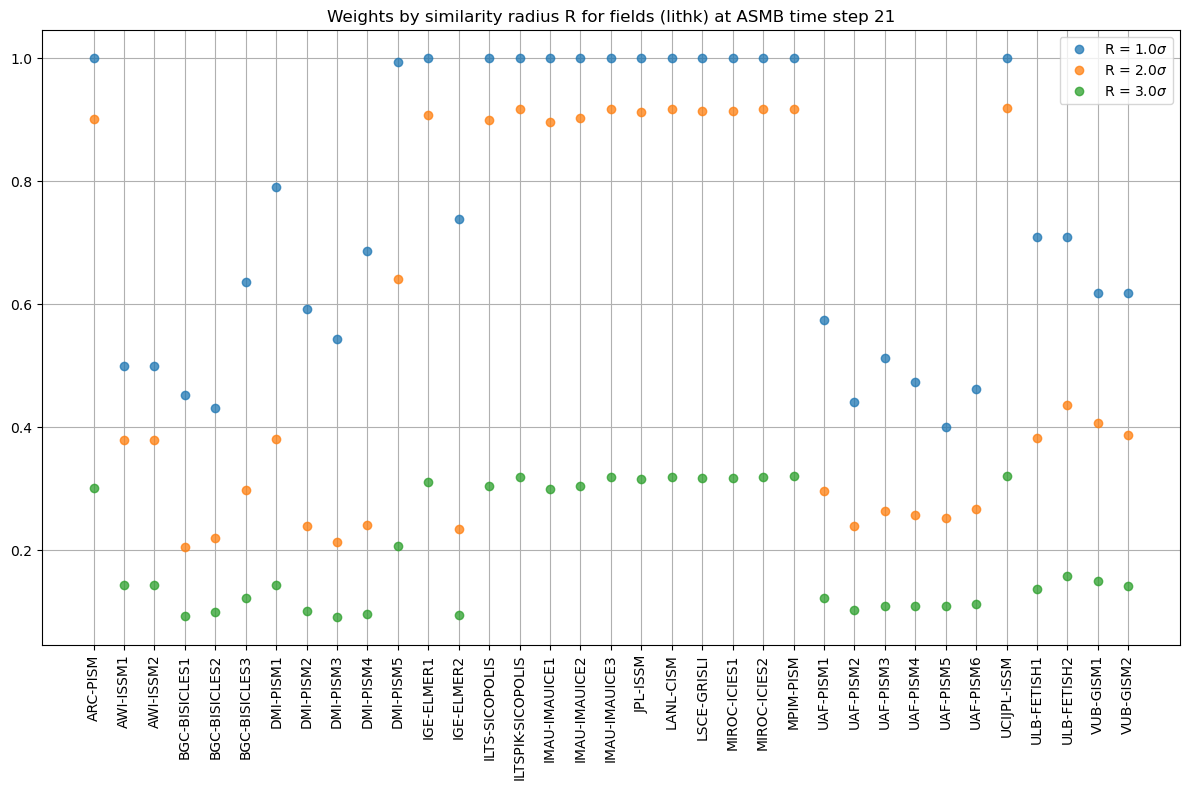

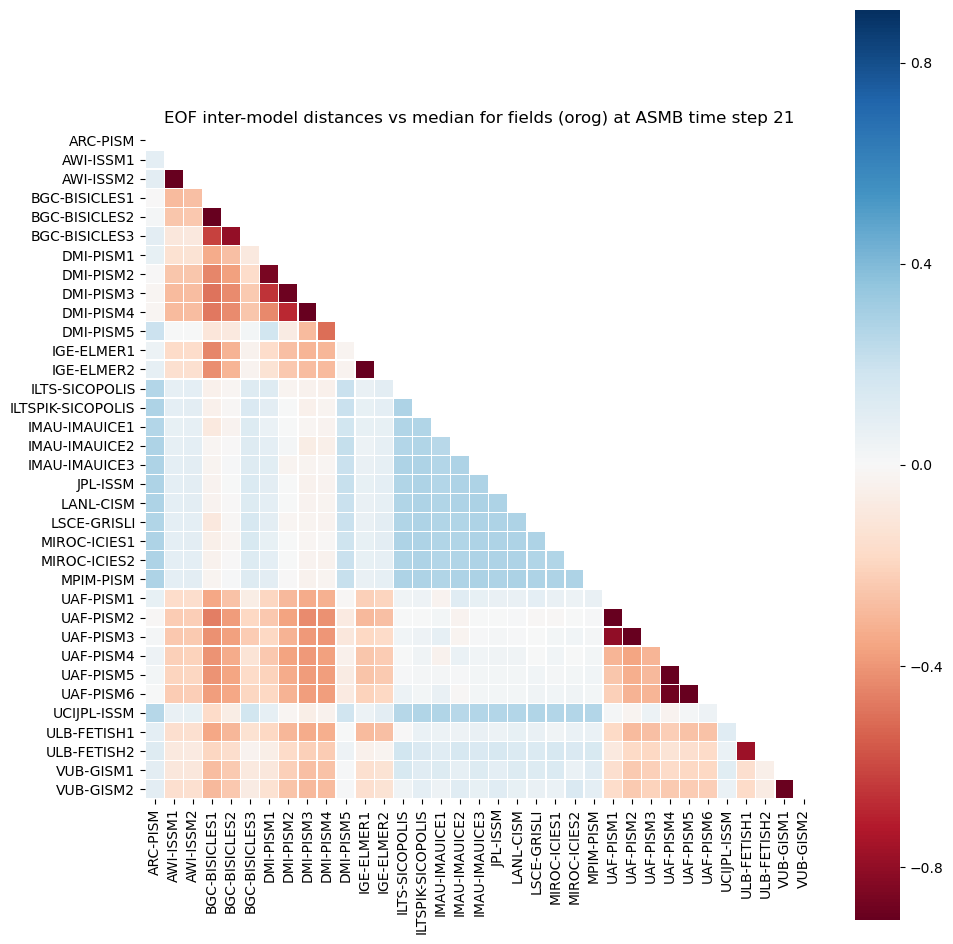

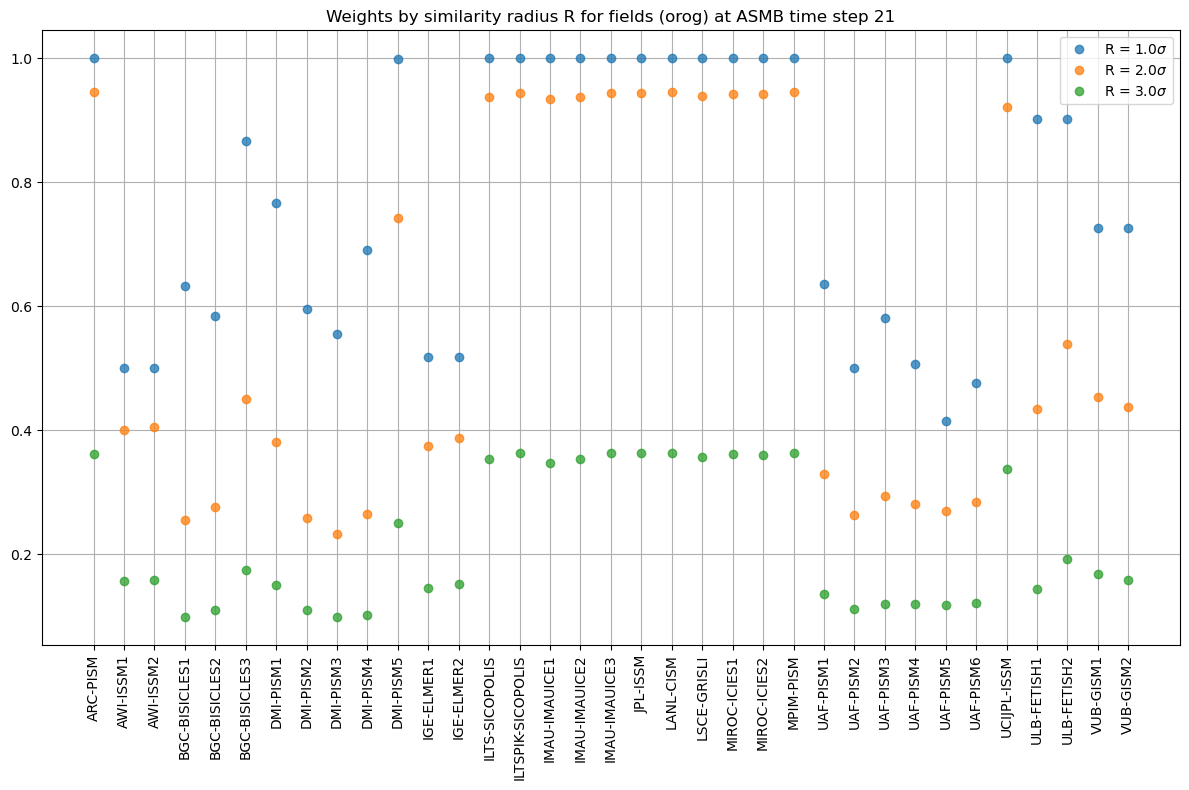

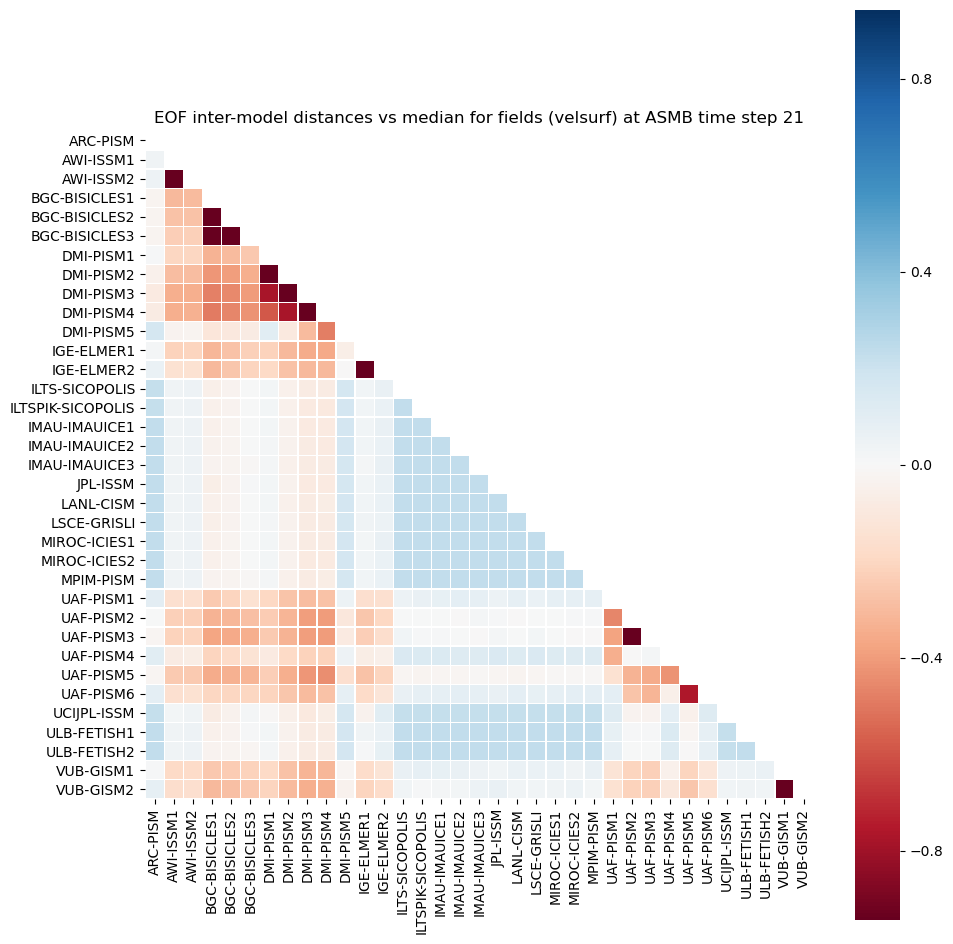

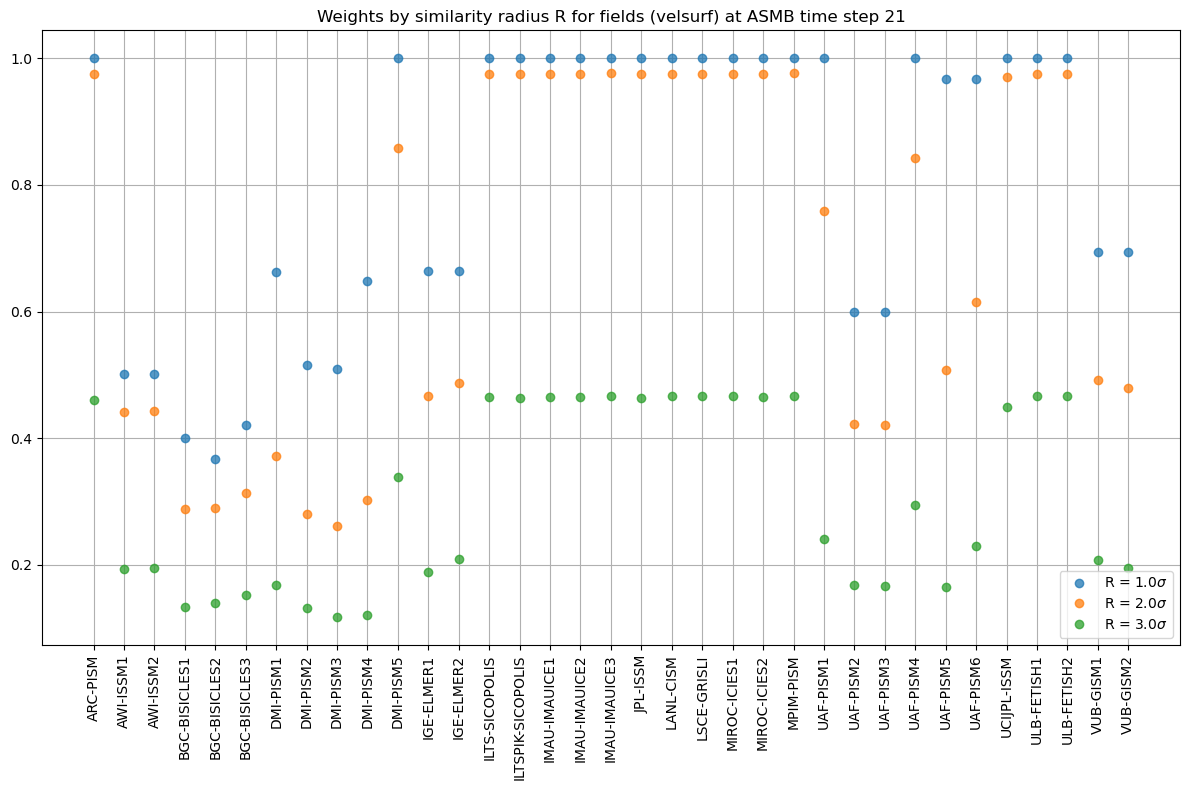

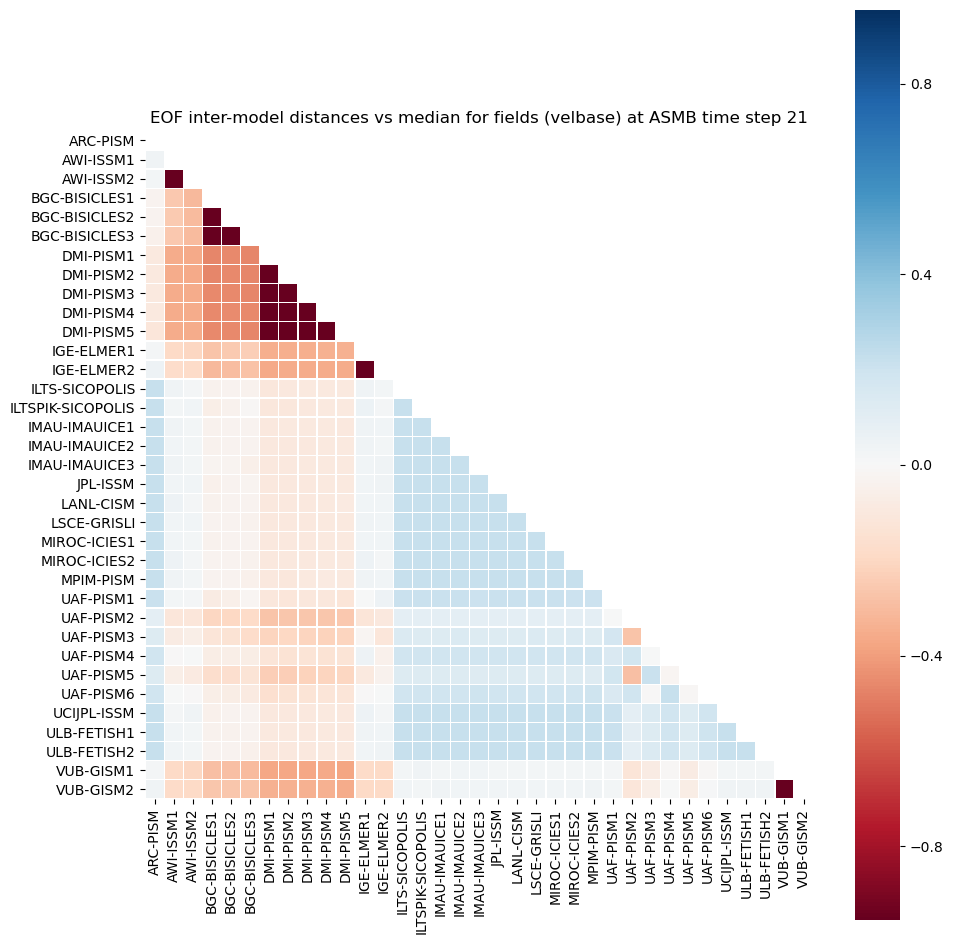

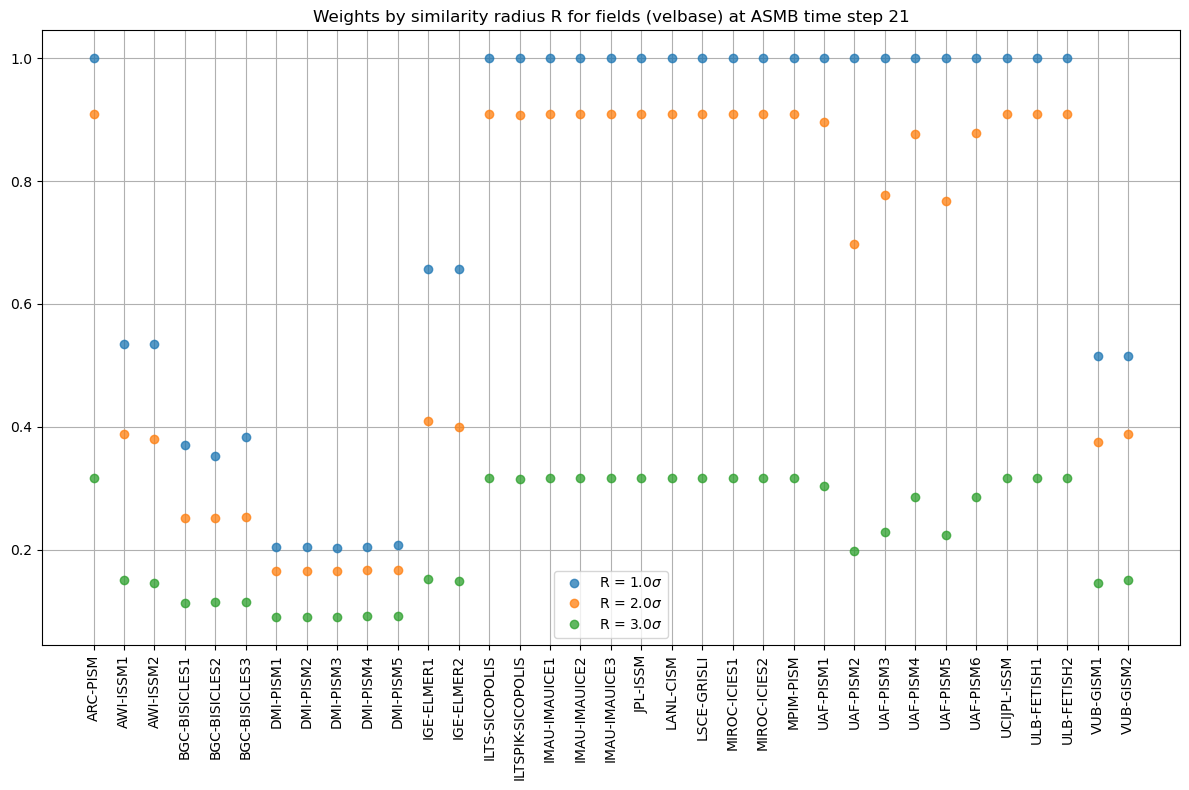

In [57]:
for exp in exps:
    for field, eof_field in fields.items(): 
        log_name = f'EOF Fields: {eof_field} [{exp.upper()}]'
        
        try:
            if isinstance(field, tuple):
                eof.eof_and_plot(models, list(field), [eof_field,], exp, step)
            else:
                eof.eof_and_plot(models, [field,], [eof_field,], exp, step)
            
            outcomes[log_name] = 'Pass'
            passed.append(eof_field)
        except FileNotFoundError as e:
            exc = traceback.format_exc(limit=0)
            file = re.search(fn_pat, exc).group(1)
            file = Path(file)
            fname = file.name
            
            outcomes[log_name] = exc
            fnf[eof_field].append(fname)
        except Exception as e:
            outcomes[log_name] = traceback.format_exc()
            ie.append(eof_field)

In [68]:
print(f'*** pass: ({len(passed)}) *** \n{passed}')
print(f'*** fnf: ({len(fnf)}) ***')
[print('  ', k, v) for k,v in fnf.items()]
print(f'*** ie: ({len(ie)}) *** \n{ie}')

*** pass: (15) *** 
['acabf', 'orog', 'velsurf', 'velbase', 'acabf', 'lithk', 'orog', 'strbasemag', 'velsurf', 'velbase', 'acabf', 'lithk', 'orog', 'velsurf', 'velbase']
*** fnf: (4) ***
   dlithkdt ['dlithkdt_GIS_DMI_PISM1_ctrl.nc', 'dlithkdt_GIS_DMI_PISM1_init.nc', 'dlithkdt_GIS_DMI_PISM1_asmb.nc']
   libmassbf ['libmassbf_GIS_IGE_ELMER1_ctrl.nc', 'libmassbf_GIS_IGE_ELMER1_init.nc', 'libmassbf_GIS_IGE_ELMER1_asmb.nc']
   litempbot ['litempbot_GIS_BGC_BISICLES1_ctrl.nc', 'litempbot_GIS_BGC_BISICLES1_init.nc', 'litempbot_GIS_BGC_BISICLES1_asmb.nc']
   litempsnic ['litempsnic_GIS_BGC_BISICLES1_ctrl.nc', 'litempsnic_GIS_BGC_BISICLES1_init.nc', 'litempsnic_GIS_BGC_BISICLES1_asmb.nc']
*** ie: (3) *** 
['lithk', 'strbasemag', 'strbasemag']


In [62]:
print(f'pass: ({len(passed)}) {passed}\nfnf: ({len(fnf)}) {fnf}\nie: ({len(ie)}) {ie}')

pass: (15) ['acabf', 'orog', 'velsurf', 'velbase', 'acabf', 'lithk', 'orog', 'strbasemag', 'velsurf', 'velbase', 'acabf', 'lithk', 'orog', 'velsurf', 'velbase']
fnf: (4) defaultdict(<class 'list'>, {'dlithkdt': ['dlithkdt_GIS_DMI_PISM1_ctrl.nc', 'dlithkdt_GIS_DMI_PISM1_init.nc', 'dlithkdt_GIS_DMI_PISM1_asmb.nc'], 'libmassbf': ['libmassbf_GIS_IGE_ELMER1_ctrl.nc', 'libmassbf_GIS_IGE_ELMER1_init.nc', 'libmassbf_GIS_IGE_ELMER1_asmb.nc'], 'litempbot': ['litempbot_GIS_BGC_BISICLES1_ctrl.nc', 'litempbot_GIS_BGC_BISICLES1_init.nc', 'litempbot_GIS_BGC_BISICLES1_asmb.nc'], 'litempsnic': ['litempsnic_GIS_BGC_BISICLES1_ctrl.nc', 'litempsnic_GIS_BGC_BISICLES1_init.nc', 'litempsnic_GIS_BGC_BISICLES1_asmb.nc']})
ie: (3) ['lithk', 'strbasemag', 'strbasemag']


### Saving Output

In [69]:
%%capture cap
for pair, o in outcomes.items():
    print(pair)
    print(o)
    print('\n')
    print('-----------------------------------------------------------')

In [71]:
with open(files.DIR_SESS_RESULTS / 'test_output.txt', 'w') as f:
    f.write(cap.stdout)